In [1]:
from ogb.nodeproppred import PygNodePropPredDataset
import torch
from torch.serialization import add_safe_globals
from torch_geometric.data import Data, Batch
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage, NodeStorage, EdgeStorage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# allowlist required torch_geometric classes for safe unpickling
add_safe_globals([DataEdgeAttr, DataTensorAttr, GlobalStorage, NodeStorage, EdgeStorage, Data, Batch])

In [3]:
# Load dataset
dataset = PygNodePropPredDataset(name="ogbn-products", root="data")
data = dataset[0]

In [4]:
print("Dataset loaded successfully!")
print(f"Total nodes: {data.x.shape[0]}")
print(f"Total edges: {data.edge_index.shape[1]}")
print(f"Node features: {data.x.shape[1]}")
print()

Dataset loaded successfully!
Total nodes: 2449029
Total edges: 123718280
Node features: 100



In [5]:
# Get label statistics for all labels
labels = data.y.squeeze()
unique_labels_all, counts_all = torch.unique(labels, return_counts=True)

In [6]:
print(f"Total unique labels: {len(unique_labels_all)}")
print(f"Label range: {unique_labels_all.min().item()} to {unique_labels_all.max().item()}")
print()

Total unique labels: 47
Label range: 0 to 46



In [7]:
# Select specific labels: 0-15 except 4
selected_labels = set(range(16)) - {4}  # {0,1,2,3,5,6,7,8,9,10,11,12,13,14,15}
print(f"Selected labels: {sorted(selected_labels)}")

Selected labels: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [8]:
# Filter unique_labels and counts to selected labels
selected_mask = torch.tensor([label.item() in selected_labels for label in unique_labels_all])
unique_labels = unique_labels_all[selected_mask]
counts = counts_all[selected_mask]

In [9]:
print(f"Filtered unique labels: {len(unique_labels)}")
print()

Filtered unique labels: 15



In [10]:
# Load category names mapping
try:
    # The mapping is stored in the dataset's meta_info
    category_names = pd.read_csv('data/ogbn_products/mapping/labelidx2productcategory.csv.gz')
    print("Category mapping loaded!")
    print(f"\nSample of label meanings:")
    print("-" * 60)
    print(category_names.head(25))
    print()
    
    # Show the selected labels specifically
    print(f"\nSelected labels and their meanings:")
    print("-" * 60)
    for label_idx in sorted(selected_labels):
        if label_idx < len(category_names):
            category = category_names.iloc[label_idx, 1]
            count = counts[unique_labels == label_idx].item() if label_idx in unique_labels else 0
            print(f"Label {label_idx}: {category} ({count:,} nodes)")
    
except Exception as e:
    print(f"Could not load category mapping: {e}")
    category_names = None


Category mapping loaded!

Sample of label meanings:
------------------------------------------------------------
    label idx           product category
0           0             Home & Kitchen
1           1     Health & Personal Care
2           2                     Beauty
3           3          Sports & Outdoors
4           4                      Books
5           5       Patio, Lawn & Garden
6           6               Toys & Games
7           7                CDs & Vinyl
8           8  Cell Phones & Accessories
9           9     Grocery & Gourmet Food
10         10      Arts, Crafts & Sewing
11         11  Clothing, Shoes & Jewelry
12         12                Electronics
13         13                Movies & TV
14         14                   Software
15         15                Video Games
16         16                 Automotive
17         17               Pet Supplies
18         18            Office Products
19         19    Industrial & Scientific
20         20        Music

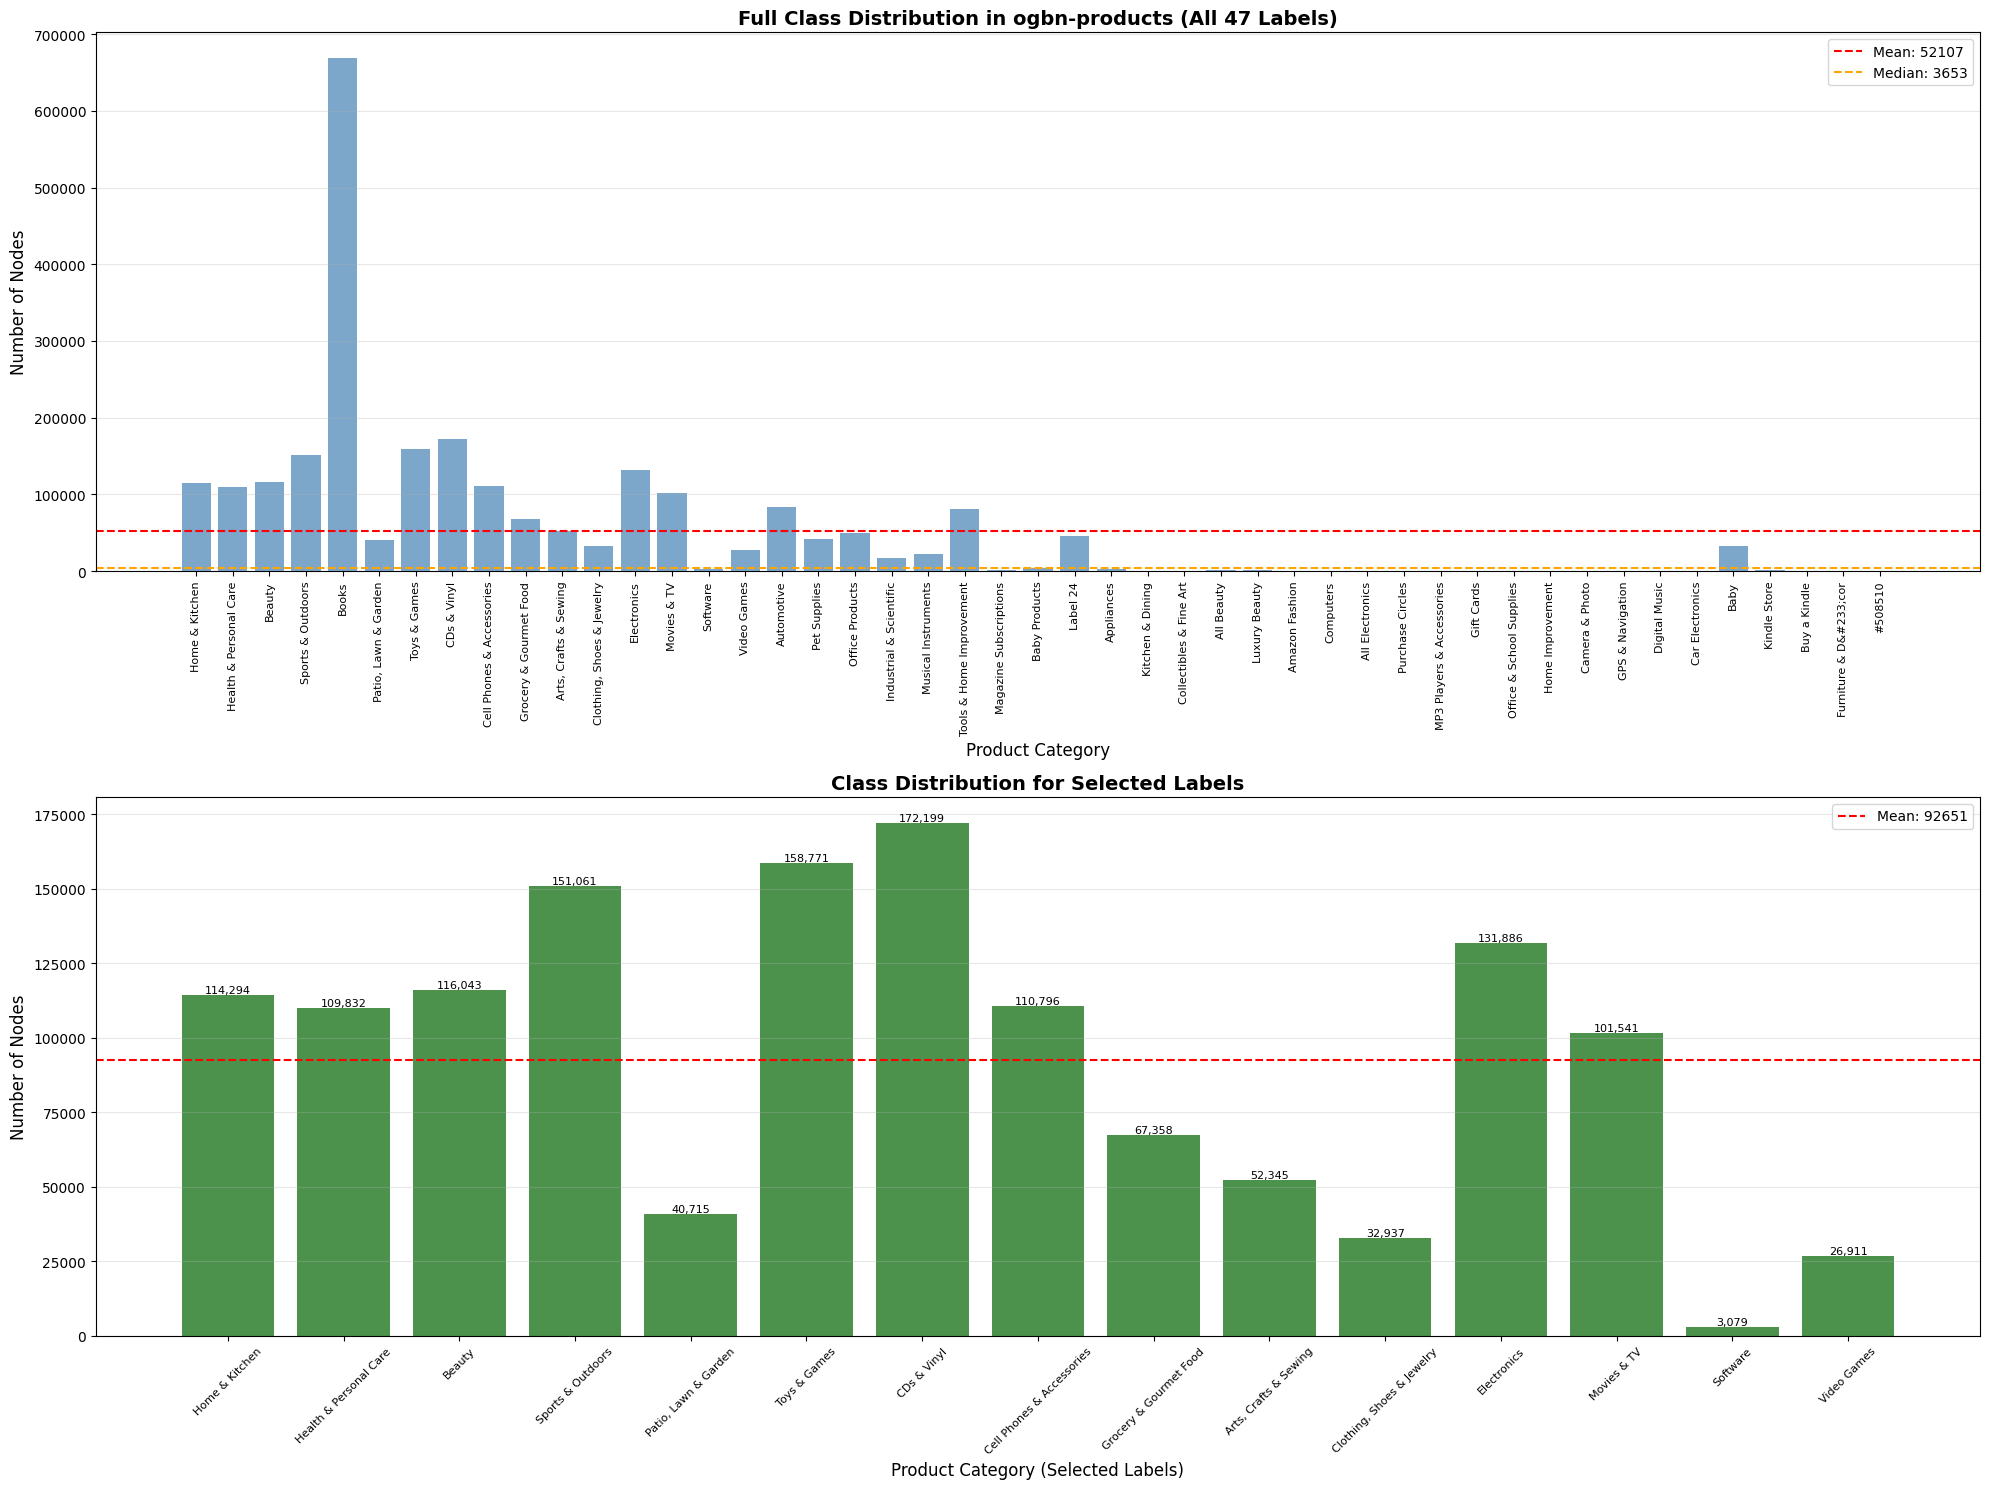

In [11]:
# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

# Plot 1: Full class distribution (all 47 labels)
ax1 = axes[0]
ax1.bar(unique_labels_all.numpy(), counts_all.numpy(), color='steelblue', alpha=0.7)
ax1.set_xlabel('Product Category', fontsize=12)
ax1.set_ylabel('Number of Nodes', fontsize=12)
ax1.set_title('Full Class Distribution in ogbn-products (All 47 Labels)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Set x-ticks to category names if available
if category_names is not None:
    category_list = []
    for i in range(len(unique_labels_all)):
        label_idx = unique_labels_all[i].item()
        if label_idx < len(category_names):
            cat = category_names.iloc[label_idx, 1]
            category_list.append(cat if isinstance(cat, str) and cat.strip() else f'Label {label_idx}')
        else:
            category_list.append(f'Label {label_idx}')
    ax1.set_xticks(unique_labels_all.numpy())
    ax1.set_xticklabels(category_list, rotation=90, fontsize=8)
else:
    ax1.set_xticks(unique_labels_all.numpy())
    ax1.set_xticklabels(unique_labels_all.numpy(), rotation=90, fontsize=8)

# Add some statistics
total_nodes_all = counts_all.sum().item()
mean_count_all = counts_all.float().mean().item()
median_count_all = counts_all.float().median().item()
ax1.axhline(y=mean_count_all, color='red', linestyle='--', label=f'Mean: {mean_count_all:.0f}')
ax1.axhline(y=median_count_all, color='orange', linestyle='--', label=f'Median: {median_count_all:.0f}')
ax1.legend()

# Plot 2: Selected classes
ax2 = axes[1]
bars = ax2.bar(range(len(unique_labels)), counts.numpy(), color='darkgreen', alpha=0.7)
ax2.set_xlabel('Product Category (Selected Labels)', fontsize=12)
ax2.set_ylabel('Number of Nodes', fontsize=12)
ax2.set_title('Class Distribution for Selected Labels', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(unique_labels)))

# Set x-ticks to category names for selected labels
if category_names is not None:
    selected_category_list = []
    for label in unique_labels:
        label_idx = label.item()
        if label_idx < len(category_names):
            cat = category_names.iloc[label_idx, 1]
            selected_category_list.append(cat if isinstance(cat, str) and cat.strip() else f'Label {label_idx}')
        else:
            selected_category_list.append(f'Label {label_idx}')
    ax2.set_xticklabels(selected_category_list, rotation=45, fontsize=8)
else:
    ax2.set_xticklabels([f'{label.item()}' for label in unique_labels], rotation=45, fontsize=8)

ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}',
             ha='center', va='bottom', fontsize=8, rotation=0)

# Add statistics for selected
selected_total = counts.sum().item()
selected_mean = counts.float().mean().item()
ax2.axhline(y=selected_mean, color='red', linestyle='--', 
            label=f'Mean: {selected_mean:.0f}')
ax2.legend()

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=300, bbox_inches='tight')


Label table saved as 'label_table.png'


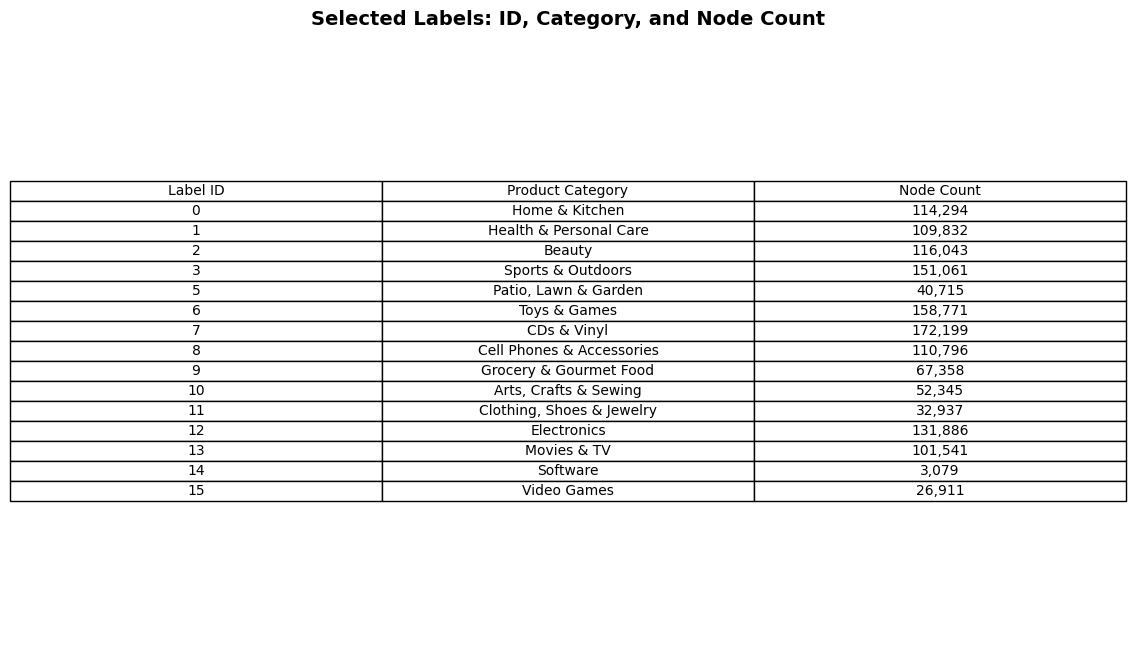

In [12]:
# Create a table for selected labels
if category_names is not None:
    table_data = []
    for label_idx in sorted(selected_labels):
        if label_idx < len(category_names):
            category = category_names.iloc[label_idx, 1]
            count = counts[unique_labels == label_idx].item() if label_idx in unique_labels else 0
            table_data.append([label_idx, category, f"{count:,}"])
    
    # Plot the table
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=table_data, colLabels=['Label ID', 'Product Category', 'Node Count'], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title('Selected Labels: ID, Category, and Node Count', fontsize=14, fontweight='bold')
    plt.savefig('label_table.png', dpi=300, bbox_inches='tight')
    print("\nLabel table saved as 'label_table.png'")
    plt.show()


In [13]:
# Print detailed statistics
print("\n" + "="*60)
print("CLASS BALANCE STATISTICS")
print("="*60)

print(f"\nAll classes:")
print(f"  Total nodes: {total_nodes_all:,}")
print(f"  Mean nodes per class: {mean_count_all:.2f}")
print(f"  Median nodes per class: {median_count_all:.2f}")
print(f"  Min nodes in a class: {counts_all.min().item():,} (Label {unique_labels_all[counts_all.argmin()].item()})")
print(f"  Max nodes in a class: {counts_all.max().item():,} (Label {unique_labels_all[counts_all.argmax()].item()})")
print(f"  Std deviation: {counts_all.float().std().item():.2f}")



CLASS BALANCE STATISTICS

All classes:
  Total nodes: 2,449,029
  Mean nodes per class: 52107.00
  Median nodes per class: 3653.00
  Min nodes in a class: 1 (Label 46)
  Max nodes in a class: 668,950 (Label 4)
  Std deviation: 105146.34


In [14]:
# Class imbalance ratio
imbalance_ratio_all = counts_all.max().item() / counts_all.min().item()
print(f"  Class imbalance ratio (max/min): {imbalance_ratio_all:.2f}x")

print(f"\nSelected classes:")
print(f"  Total nodes: {selected_total:,}")
print(f"  Mean nodes per class: {selected_mean:.2f}")
print(f"  Median nodes per class: {counts.float().median().item():.2f}")
print(f"  Min nodes in a class: {counts.min().item():,} (Label {unique_labels[counts.argmin()].item()})")
print(f"  Max nodes in a class: {counts.max().item():,} (Label {unique_labels[counts.argmax()].item()})")
print(f"  Std deviation: {counts.float().std().item():.2f}")


  Class imbalance ratio (max/min): 668950.00x

Selected classes:
  Total nodes: 1,389,768
  Mean nodes per class: 92651.20
  Median nodes per class: 109832.00
  Min nodes in a class: 3,079 (Label 14)
  Max nodes in a class: 172,199 (Label 7)
  Std deviation: 52264.59


In [15]:
# Class imbalance ratio
imbalance_ratio = counts.max().item() / counts.min().item()
print(f"  Class imbalance ratio (max/min): {imbalance_ratio:.2f}x")

plt.show()

  Class imbalance ratio (max/min): 55.93x
